In [32]:
import gym

class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()

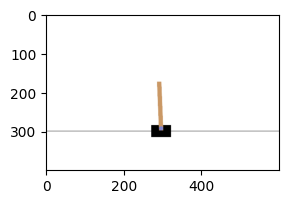

In [33]:
env = MyWrapper()

env.reset()

env.show()

In [34]:
import torch
import random
from collections import deque
import numpy as np

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)

In [35]:
# 演员模型,计算每个动作的概率
model_actor = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

# 评委模型,计算每个状态的价值
model_critic = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

# 延遲評委模型, 用於穩定訓練
model_critic_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_critic_delay.load_state_dict(model_critic.state_dict())

<All keys matched successfully>

In [36]:
optimizer_actor = torch.optim.Adam(model_actor.parameters(), lr=1e-3)
optimizer_critic = torch.optim.Adam(model_critic.parameters(), lr=1e-2)

def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)


In [37]:
def train_critic(state, reward, next_state, over):
    requires_grad(model_actor, False)
    requires_grad(model_critic, True)

    value = model_critic(state)

    with torch.no_grad():
        target = model_critic_delay(next_state)
    target = target * 0.99 * (1 - over) + reward

    loss = torch.nn.functional.mse_loss(value, target)

    loss.backward()
    optimizer_critic.step()
    optimizer_critic.zero_grad()

    return (target - value).detach()

In [38]:
def train_actor(state, action, value):
    requires_grad(model_actor, True)
    requires_grad(model_critic, False)

    prob = model_actor(state)
    prob = prob.gather(dim=1, index=action)

    prob = (prob + 1e-8).log() * value
    loss = -prob.mean()

    loss.backward()
    optimizer_actor.step()
    optimizer_actor.zero_grad()

    return loss.item()


In [39]:
replay_buffer = ReplayBuffer(capacity=10000)

batch_size = 64
soft_update_rate = 0.3

for epoch in range(1000):
    state = env.reset()
    total_reward = 0
    
    while True:
        with torch.no_grad():
            prob = model_actor(torch.FloatTensor(state).reshape(1, 4))[0].tolist()
        action = random.choices(range(2), weights=prob, k=1)[0]

        next_state, reward, done = env.step(action)
        
        replay_buffer.push(state, action, reward, next_state, done)
        
        total_reward += reward
        state = next_state

        if len(replay_buffer) > batch_size:
            
            b_state, b_action, b_reward, b_next_state, b_done = replay_buffer.sample(batch_size)
            
            b_state = torch.FloatTensor(b_state).reshape(-1, 4)
            b_action = torch.LongTensor(b_action).reshape(-1, 1)
            b_reward = torch.FloatTensor(b_reward).reshape(-1, 1)
            b_next_state = torch.FloatTensor(b_next_state).reshape(-1, 4)
            b_done = torch.LongTensor(b_done).reshape(-1, 1)

            advantage = train_critic(b_state, b_reward, b_next_state, b_done)
            loss = train_actor(b_state, b_action, advantage)

            for param, param_delay in zip(model_critic.parameters(), model_critic_delay.parameters()):
                value = param_delay.data * (1.0 - soft_update_rate) + param.data * soft_update_rate
                param_delay.data.copy_(value)

        if done:
            break
            
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Total Reward: {total_reward}")

Epoch: 0, Total Reward: -981.0
Epoch: 100, Total Reward: -884.0
Epoch: 200, Total Reward: 200.0
Epoch: 300, Total Reward: 200.0
Epoch: 400, Total Reward: 200.0
Epoch: 500, Total Reward: 200.0
Epoch: 600, Total Reward: 200.0
Epoch: 700, Total Reward: 200.0
Epoch: 800, Total Reward: 200.0
Epoch: 900, Total Reward: 200.0


In [41]:
    from IPython import display
    
    def test_agent_and_show():
        """
        此函式用於在訓練完成後, 觀看 agent 的表現。
        """
        # 將模型設為評估模式
        model_actor.eval()
    
        # 建立一個新的環境來顯示
        env_show = MyWrapper()
        state = env_show.reset()
        done = False
        total_reward = 0

        print("--- 觀看訓練成果 ---")
        while not done:
            # 顯示畫面
            display.clear_output(wait=True)
            env_show.show()
    
            # 選擇動作 (測試時通常選機率最高的動作，而不是隨機採樣)
            with torch.no_grad():
                prob = model_actor(torch.FloatTensor(state).reshape(1, 4))[0].tolist()
                action = prob.index(max(prob))
    
            # 與環境互動
            next_state, reward, done = env_show.step(action)

            total_reward += reward
            state = next_state

        print(f"測試完成，總分: {total_reward}")
        return total_reward

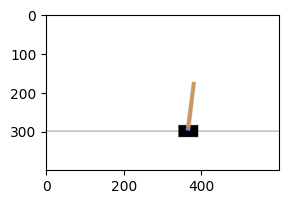

測試完成，總分: 200.0


200.0

In [42]:
test_agent_and_show()

 在我們重構後的訓練程式碼中，已經不再需要 play() 函式了。

  原因是：
  play() 的作用是「一次性跑完一整局遊戲，並收集所有資料」。

  但在新的架構中，我們的主訓練迴圈是一步一步地與環境互動，並將每一步的經驗 (state, action, reward...) 即時存入 Replay Buffer。然後，訓練是從
  Replay Buffer 中抽樣，而不是使用 play() 收集的整局資料。

  所以，新的訓練迴圈本身就包含了與環境互動的邏輯，完全取代了 play() 函式在訓練過程中的角色。

 您不想要我之前寫的那種「邊玩邊學」的線上模式，而是想要一個更明確的兩階段過程：
   1. 預填充階段：先進行大量的探索，用初始數據填滿數據池。
   2. 訓練階段：從數據池中抽樣進行訓練，同時，每訓練一次，就去玩一局新的遊戲，把新的數據再放回池中，實現數據的持續更新。

  這是一個很常見且有效的作法。您提到 chap01 有類似做法，為了完全符合您的思想，我將先讀取 chap01 的檔案來確認這個模式。
 ╭────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
 │ ✔ ReadManyFiles Will attempt to read and concatenate files using patterns:…                                                       │
 │                                                                                                                                    │
 │                                                                                                                                    │
 │    ### ReadManyFiles Result (Target Dir: `D:\it_project\github_sync\ml-workshop`)                                                  │
 │                                                                                                                                    │
 │    Successfully read and concatenated content from **3 file(s)**.                                                                  │
 │                                                                                                                                    │
 │    **Processed Files:**                                                                                                            │
 │    - `more_simple_reinforcement_learning/chap_01_q_learning_pools_and_sarsa/01_QLearning.ipynb`                                    │
 │    - `more_simple_reinforcement_learning/chap_01_q_learning_pools_and_sarsa/02_SARSA_no_pool.ipynb`                                │
 │    - `more_simple_reinforcement_learning/chap_01_q_learning_pools_and_sarsa/03_n_step_TD_learning.ipynb`                           │
 ╰────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
✦ 好的，我已經詳細閱讀了 chap01 的程式碼，特別是
  01_QLearning.ipynb，現在完全理解您想要的「先用一批新數據更新數據池，然後再從池中抽樣訓練」的模式了。

  這和我們之前討論的「即時線上學習」模式確實不同。我將為您重寫訓練迴圈，以符合這個新邏輯。

  這個新模式需要一個輔助函式來「玩一局遊戲並收集數據」，我們將重新引入一個類似 play 的函式，但只用於數據收集。

  ---

  1. 輔助函式：`generate_episode_data`
  這個函式負責玩一局遊戲，並返回該局的所有步驟數據。

    1 def generate_episode_data():
    2     """
    3     玩一局完整的遊戲, 並返回所有(s, a, r, ns, done)的list
    4     """
    5     data = []
    6     state = env.reset()
    7     done = False
    8     while not done:
    9         with torch.no_grad():
   10             prob = model_actor(torch.FloatTensor(state).reshape(1, 4))[0].tolist()
   11         action = random.choices(range(2), weights=prob, k=1)[0]
   12
   13         next_state, reward, done = env.step(action)
   14         data.append((state, action, reward, next_state, done))
   15         state = next_state
   16
   17     return data

  ---

  2. 核心訓練迴圈 (新)
  這就是您想要的，包含「預填充」和「訓練並更新」兩個階段的訓練迴圈。

    1 def train_main():
    2     # --- 超參數 ---
    3     REPLAY_BUFFER_CAPACITY = 50000 # 數據池總容量
    4     PREFILL_EPISODES = 200        # 預填充的遊戲局數 (您提到的10000局會非常久, 先用200局示範)
    5
    6     EPOCHS = 2000                 # 總訓練輪次
    7     EPISODES_PER_EPOCH = 5        # 每一輪更新時, 要玩幾局新遊戲
    8     TRAIN_STEPS_PER_EPOCH = 200   # 每一輪更新時, 要訓練幾步
    9
   10     BATCH_SIZE = 64
   11     SOFT_UPDATE_RATE = 0.3
   12
   13     # --- 初始化 ---
   14     replay_buffer = ReplayBuffer(capacity=REPLAY_BUFFER_CAPACITY)
   15
   16     # --- 階段 1: 預填充數據池 ---
   17     print("--- 正在預填充數據池... ---")
   18     for _ in range(PREFILL_EPISODES):
   19         episode_data = generate_episode_data()
   20         replay_buffer.buffer.extend(episode_data)
   21     print(f"--- 預填充完成，數據池大小: {len(replay_buffer)} ---")
   22
   23     # --- 階段 2: 主訓練迴圈 ---
   24     for epoch in range(EPOCHS):
   25
   26         # 2a. 玩新的遊戲，並將數據加入數據池
   27         for _ in range(EPISODES_PER_EPOCH):
   28             episode_data = generate_episode_data()
   29             replay_buffer.buffer.extend(episode_data)
   30
   31         # 2b. 從數據池中抽樣，進行訓練
   32         for _ in range(TRAIN_STEPS_PER_EPOCH):
   33             # 從 buffer 中抽樣一個 batch
   34             b_state, b_action, b_reward, b_next_state, b_done = replay_buffer.sample(BATCH_SIZE)
   35
   36             # 將 numpy array 轉換為 tensor
   37             b_state = torch.FloatTensor(b_state).reshape(-1, 4)
   38             b_action = torch.LongTensor(b_action).reshape(-1, 1)
   39             b_reward = torch.FloatTensor(b_reward).reshape(-1, 1)
   40             b_next_state = torch.FloatTensor(b_next_state).reshape(-1, 4)
   41             b_done = torch.LongTensor(b_done).reshape(-1, 1)
   42
   43             # 訓練兩個模型 (使用抽樣的 batch)
   44             advantage = train_critic(b_state, b_reward, b_next_state, b_done)
   45             loss = train_actor(b_state, b_action, advantage)
   46
   47             # 軟更新延遲網路
   48             for param, param_delay in zip(model_critic.parameters(), model_critic_delay.parameters()):
   49                 value = param_delay.data * (1.0 - SOFT_UPDATE_RATE) + param.data * SOFT_UPDATE_RATE
   50                 param_delay.data.copy_(value)
   51
   52         # 定期評估並印出結果
   53         if epoch % 100 == 0:
   54             test_reward = test_agent_and_show() # 假設 test_agent_and_show() 函式已定義
   55             print(f"Epoch {epoch}, Buffer: {len(replay_buffer)}, Test Reward: {test_reward}")
   56
   57 # --- 最終執行 ---
   58 # train_main()